Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

# PSI3471 - Aula de Exercícios 05

# MLP e o otimizador Adam

Neste exercício vamos treinar uma rede MLP com o algorotimo backpropagation e comparar com o otimizador Adam no modo mini-batch para o caso das meias-luas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Vamos gerar os dados de treinamento do problema das meias-luas.

In [2]:
def meias_luas(NA, NB, r1, r2, r3):
    """
    dados = meias_luas(NA,NB,r1,r2,r3)
    NA: número de pontos da região A
    NB: número de pontos da região B
    r1, r2 e r3: dados das meias-luas
    """

    # total de dados de treinamento
    Nt = NA + NB

    # dados das meia luas
    rmin = r1 - r3 / 2
    rmax = r1 + r3 / 2

    # Pontos da Região A
    a = np.pi * np.random.rand(NA, 1)
    rxy = np.random.uniform(rmin, rmax, (NA, 1))
    x1A = rxy * np.cos(a)
    x2A = rxy * np.sin(a)
    dA = np.ones((NA, 1))
    pontosA = np.hstack((x1A, x2A, dA))

    # Pontos da Região B
    a = np.pi * np.random.rand(NB, 1)
    rxy = np.random.uniform(rmin, rmax, (NB, 1))
    x1B = rxy * np.cos(a) + r1
    x2B = -rxy * np.sin(a) - r2
    dB = -np.ones((NB, 1))
    pontosB = np.hstack((x1B, x2B, dB))

    # Concatenando e embaralhando os dados
    dados = np.vstack((pontosA, pontosB))
    np.random.shuffle(dados)

    # Figura para mostrar os dados de treino
    fig, ax1 = plt.subplots()
    ax1.plot(x1A, x2A, ".b")
    ax1.plot(x1B, x2B, ".r")
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.grid(axis="x", color="0.5")
    plt.grid(axis="y", color="0.5")

    return dados

Gera dados de treinamento

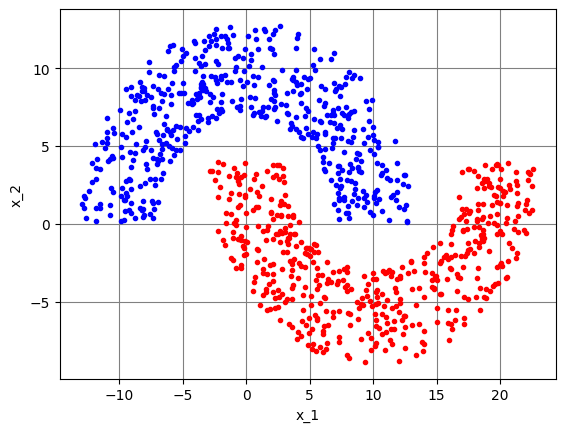

In [3]:
# número de pontos de treinamento da Região A
NA = 500

# número de pontos de treinamento da Região B
NB = 500

# número total de dados de treinamento
Nt = NA + NB

r1 = 10
r3 = 6
r2 = -4

dados_treino = meias_luas(NA, NB, r1, r2, r3)

In [4]:
# organizando os dados para entrada da MLP

# sinal de entrada
x = dados_treino[:, [0, 1]]

# sinal desejado
d = dados_treino[:, [2]]

In [5]:
def redeMLP_SGD(x, d, Nn, eta, Nt, Nb, Ne, W0):
    """
    J_MSE, W = redeMLP_SGD(x, d, Nn, eta, Nt, Nb, Ne, W0)
    Saídas:
    J_MSE: valor da função custo ao longo das épocas
    W: matriz de pesos (inclui o bias) da última época
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Nb: tamanho do mini-batch
    Ne: número de épocas
    W0: matriz de pesos (inclui o bias)
    """

    # número de camadas (desconta-se 1, pois na posição 0
    # o vetor Nn contém o número de entradas da rede)
    L = len(Nn) - 1

    # número de neurônios da camada de saída
    NL = Nn[L]

    # número de mini-batches por época
    Nmb = int(np.floor(Nt / Nb))

    # inicialização da matriz W
    W = W0.copy()

    # inicialização da matriz de gradientes
    Delta = 0 * W

    # passo de adaptação dividido pelo tamanho do mini-batch
    eta = eta / Nb

    # inicialização do vetor que contém o valor da função custo
    J_MSE = np.zeros((Ne, 1))

    # Juntamos o vetor de entrada com o sinal desejado e inserimos
    # uma coluna de uns para levar em conta o bias
    Xd = np.hstack((np.ones((Nt, 1)), x, d))

    # vetor de uns para o bias no mini-batch
    b = np.ones((Nb, 1))

    # for das épocas
    for k in range(Ne):
        np.random.shuffle(Xd)
        X = Xd[:, 0 : Nn[0] + 1]
        d = Xd[:, [Nn[0] + 1]]

        # for dos mini-batches
        for l in range(Nmb):
            dmb = d[l * Nb : (l + 1) * Nb].reshape(-1, 1)
            Xmb = X[l * Nb : (l + 1) * Nb, :]
            dphi = np.zeros((Nb, max(Nn), L))
            XXmb = np.zeros((Nb, max(Nn) + 1, L))

            # for das camadas no cálculo progressivo
            for j in range(L):
                vmb = Xmb @ W[0 : Nn[j + 1], 0 : Nn[j] + 1, j].T
                ymb = np.tanh(vmb)
                dphi[:, 0 : Nn[j + 1], j] = 1 - ymb**2

                # guarda a entrada da camada atual para atualização dos pesos
                XXmb[:, 0 : Nn[j] + 1, j] = Xmb

                # entrada da acmada seguinte formada por um vertor de uns por
                # causa dos bias e o vetor que corresponde à saída da camada atual
                Xmb = np.hstack((b, ymb))

            # erro da última camada
            emb = dmb - ymb

            # for das camadas no cálculo regressivo para atualização dos pesos
            for j in range(L, 0, -1):

                # Cálculo dos gradientes locais e da matriz de gradientes
                if j == L:
                    delta = emb * dphi[:, 0 : Nn[j], j - 1]
                    Delta[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1] = (
                        delta.T @ XXmb[:, 0 : Nn[j - 1] + 1, j - 1]
                    )
                else:
                    delta_aux = delta @ W[0 : Nn[j + 1], 1 : Nn[j] + 1, j]
                    delta = dphi[:, 0 : Nn[j], j - 1] * delta_aux
                    Delta[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1] = (
                        delta.T @ XXmb[:, 0 : Nn[j - 1] + 1, j - 1]
                    )

            for j in range(L, 0, -1):

                # Atualização dos pesos e biases
                W[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1] = (
                    W[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1]
                    + eta * Delta[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1]
                )

            # guarda no vetor J_MSE a norma do vertor de erros de saída ao quadrado
            J_MSE[k] = J_MSE[k] + (np.linalg.norm(emb)) ** 2

        # cálculo do MSE (divide o valor acumulado pelo número de
        # mini-batches x tamanho do batch x número de neurônios
        # da camada de saída)
        J_MSE[k] = J_MSE[k] / (Nmb * Nb * NL)

        if k % 100 == 0:
            print(f"SGD - Época: {k}", f"MSE: {J_MSE[k]}")
    return J_MSE, W

<div class="alert alert-block alert-success">
Complete o código a seguir:
</div>

In [7]:
def redeMLP_Adam(x, d, Nn, eta, Nt, Nb, Ne, W0, beta1, beta2, epsilon):
    """
    J_MSE, W = redeMLP(x, d, Nn, eta, Nt, Nb, Ne, W0, beta1, beta2, epsilon)
    Saídas:
    J_MSE: valor da função custo ao longo das épocas
    W: matriz de pesos (inclui o bias) da última época
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Nb: tamanho do mini-batch
    Ne: número de épocas
    W0: matriz de pesos (inclui o bias)
    beta1, beta2: fatores de esquecimento do otimizador Adam (e.g., beta1 = beta2 = 0.99)
    epsilon: constante para evitar divisão por zero no Adam (e.g. epsilon = 1e-4)
    """

    # número de camadas (desconta-se 1, pois na posição 0 o vetor Nn contém o número de entradas da rede)
    L = len(Nn) - 1

    # número de neurônios da camada de saída
    NL = Nn[L]

    # número de mini-batches por época
    Nmb = int(np.floor(Nt / Nb))

    # inicialização da matriz W
    W = W0.copy()

    # inicialização da matriz de gradientes
    Delta = 0 * W

    # passo de adaptação dividido pelo tamanho do mini-batch
    eta = eta / Nb

    # inicialização do vetor que contém o valor da função custo
    J_MSE = np.zeros((Ne, 1))

    # Juntamos o vetor de entrada com o sinal desejado e inserimos
    # uma coluna de uns para levar em conta o bias
    Xd = np.hstack((np.ones((Nt, 1)), x, d))

    # vetor de uns para o bias no mini-batch
    b = np.ones((Nb, 1))

    # inicialização das matrizes S e V
    S = 0 * W0
    V = 0 * W0
    m = 1  # contador de iteração

    # for das épocas
    for k in range(Ne):
        np.random.shuffle(Xd)
        X = Xd[:, 0 : Nn[0] + 1]
        d = Xd[:, [Nn[0] + 1]]

        # for dos mini-batches
        for l in range(Nmb):
            dmb = d[l * Nb : (l + 1) * Nb].reshape(-1, 1)
            Xmb = X[l * Nb : (l + 1) * Nb, :]
            dphi = np.zeros((Nb, max(Nn), L))
            XXmb = np.zeros((Nb, max(Nn) + 1, L))

            # for das camadas no cálculo progressivo
            for j in range(L):
                vmb = Xmb @ W[0 : Nn[j + 1], 0 : Nn[j] + 1, j].T
                ymb = np.tanh(vmb)
                dphi[:, 0 : Nn[j + 1], j] = 1 - ymb**2

                # guarda a entrada da camada atual para atualização dos pesos
                XXmb[:, 0 : Nn[j] + 1, j] = Xmb

                # entrada da acmada seguinte formada por um vertor de uns por
                # causa dos bias e o vetor que corresponde à saída da camada atual
                Xmb = np.hstack((b, ymb))

            # erro da última camada
            emb = dmb - ymb

            # for das camadas no cálculo regressivo para atualização dos pesos
            for j in range(L, 0, -1):

                # Cálculo dos gradientes locais e da matriz de gradientes
                if j == L:
                    delta = emb * dphi[:, 0 : Nn[j], j - 1]
                    Delta[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1] = (
                        delta.T @ XXmb[:, 0 : Nn[j - 1] + 1, j - 1]
                    )

                else:
                    delta_aux = delta @ W[0 : Nn[j + 1], 1 : Nn[j] + 1, j]
                    delta = dphi[:, 0 : Nn[j], j - 1] * delta_aux
                    Delta[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1] = (
                        delta.T @ XXmb[:, 0 : Nn[j - 1] + 1, j - 1]
                    )

            for j in range(L, 0, -1):

                # Atualização dos pesos e biases
                #############
                V[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1] = beta1*V[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1] + (1-beta1)*Delta[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1]
                S[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1] = beta2*S[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1] + (1-beta2)*Delta[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1]**2

                Vb = V[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1]/(1-beta1**m)

                Sb = S[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1]/(1-beta2**m)

                W[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1] = W[0 : Nn[j], 0 : Nn[j - 1] + 1, j - 1] + eta*Vb/(np.sqrt(Sb) +epsilon)
                #############

            m = m + 1  # incrementa o número da iteração

            # guarda no vetor J_MSE a norma do vertor de erros de saída ao quadrado
            J_MSE[k] = J_MSE[k] + (np.linalg.norm(emb)) ** 2

        # cálculo do MSE (divide o valor acumulado pelo número de
        # mini-batches x tamanho do batch x número de neurônios
        # da camada de saída)
        J_MSE[k] = J_MSE[k] / (Nmb * Nb * NL)

        if k % 100 == 0:
            print(f"Adam - Época: {k}", f"MSE: {J_MSE[k]}")
    return J_MSE, W

In [8]:
# Parâmetros da rede

# passo de adaptação da rede MLP
eta = 0.5

# número de entradas da rede
N0 = 2

# vetor que contém o número de neurônios em cada camada,
# mas na posição 0, contém o número de entradas da rede
Nn = [N0, 3, 5, 5, 2, 1]

# número de camadas
L = len(Nn) - 1

# Inicialização dos pesos
W0 = 0.02 * np.random.rand(np.max(Nn), np.max(Nn) + 1, L) - 0.01

Treinamento da MLP

In [9]:
# Treinamento

# Tamanho do mini-batch
Nb = 50

# Número de épocas
Ne = 5000

# Hiperparâmetros do Adam
beta1 = 0.99
beta2 = 0.99
epsilon = 1e-4

# Treinamento com o backpropagation
(J_MSE_SGD, W_SGD) = redeMLP_SGD(x, d, Nn, eta, Nt, Nb, Ne, W0)

# Treinamento com o otimizador Adam
(J_MSE_Adam, W_Adam) = redeMLP_Adam(
    x, d, Nn, eta, Nt, Nb, Ne, W0, beta1, beta2, epsilon
)

SGD - Época: 0 MSE: [1.00958396]
SGD - Época: 100 MSE: [1.00799604]
SGD - Época: 200 MSE: [1.00583015]
SGD - Época: 300 MSE: [1.00309231]
SGD - Época: 400 MSE: [1.00611913]
SGD - Época: 500 MSE: [1.01273099]
SGD - Época: 600 MSE: [1.00644833]
SGD - Época: 700 MSE: [1.0121119]
SGD - Época: 800 MSE: [1.01369004]
SGD - Época: 900 MSE: [1.01289707]
SGD - Época: 1000 MSE: [1.00617506]
SGD - Época: 1100 MSE: [1.00398096]
SGD - Época: 1200 MSE: [1.01029519]
SGD - Época: 1300 MSE: [1.00788056]
SGD - Época: 1400 MSE: [1.00781342]
SGD - Época: 1500 MSE: [1.00305765]
SGD - Época: 1600 MSE: [0.99922118]
SGD - Época: 1700 MSE: [1.00520349]
SGD - Época: 1800 MSE: [1.01375914]
SGD - Época: 1900 MSE: [1.00641154]
SGD - Época: 2000 MSE: [1.00307766]
SGD - Época: 2100 MSE: [1.01015083]
SGD - Época: 2200 MSE: [1.00924712]
SGD - Época: 2300 MSE: [1.00855349]
SGD - Época: 2400 MSE: [1.01230401]
SGD - Época: 2500 MSE: [1.00431791]
SGD - Época: 2600 MSE: [1.00761393]
SGD - Época: 2700 MSE: [1.0034558]
SGD - 

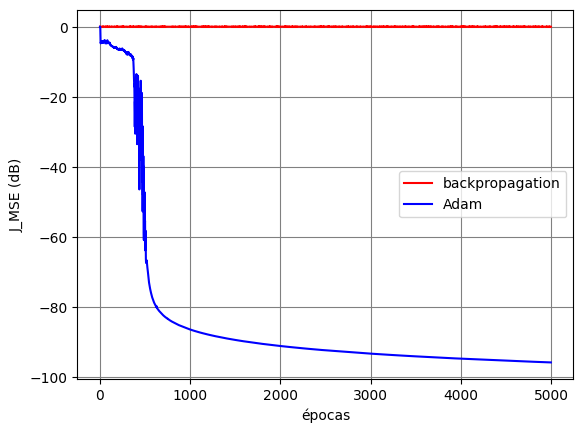

In [10]:
# Mostra a função custo ao longo das épocas

plt.figure()
J_MSEdB_SGD = 10 * np.log10(J_MSE_SGD)
J_MSEdB_Adam = 10 * np.log10(J_MSE_Adam)
plt.plot(J_MSEdB_SGD, "r", label="backpropagation")
plt.plot(J_MSEdB_Adam, "b", label="Adam")
plt.ylabel("J_MSE (dB)")
plt.grid(axis="x", color="0.5")
plt.grid(axis="y", color="0.5")
plt.xlabel("épocas")
plt.legend()

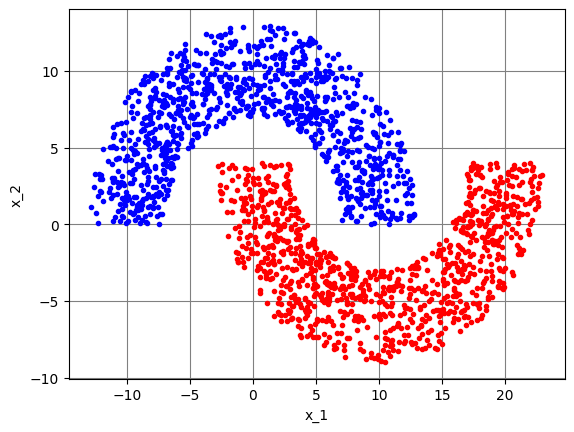

In [11]:
# Dados de teste
NAt = 1000
NBt = 1000
Nteste = NAt + NBt

dados_teste = meias_luas(NAt, NBt, r1, r2, r3)

# entrada
xteste = dados_teste[:, 0:2]  # sinal de entrada

# sinal desejado
dteste = dados_teste[:, 2].reshape(-1, 1)

In [12]:
def redeMLP_teste(x, d, W, Nn, Nteste):
    """
    J_MSE,y = redeMLP_teste(x, d, W, Nn, Nteste)
    Saídas:
    J_MSE: valor da função custo no teste
    y: saída da rede MLP
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    W: matriz de pesos (inclui o bias) da última época
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    Nteste: número de dados de teste
    """

    # vetor de 1's
    b = np.ones((Nteste, 1))

    # inseri 1's ao vetor de entrada
    x = np.hstack((b, x))

    # número de camadas (desconta-se 1, pois na posição 0 o vetor
    # Nn contém o número de entradas da rede)
    L = len(Nn) - 1

    # número de neurônios da camada de saída
    NL = Nn[L]

    J_MSE = np.zeros((Nteste, 1))
    y = np.zeros((Nteste, NL))
    e = np.zeros((Nteste, NL))
    b = 1

    for n in range(Nteste):
        X = x[n, :]

        # cálculo progressivo com os pesos fixos da última época
        for j in range(L):
            v = X @ W[0 : Nn[j + 1], 0 : Nn[j] + 1, j].T
            yc = np.tanh(v)
            X = np.hstack((b, yc))
        y[n, :] = yc
        e[n, :] = d[n, :] - y[n, :]
        J_MSE[n] = (J_MSE[n] + (np.linalg.norm(e[n, :])) ** 2) / (Nn[L])

    return J_MSE, y

Teste da rede MLP (apenas o cálculo progressivo com pesos da última época)

In [13]:
# teste com a MLP treinada com o backpropagation
(J_MSEteste_SGD, yteste_SGD) = redeMLP_teste(xteste, dteste, W_SGD, Nn, Nteste)

# teste com a MLP treinada com o otimizador Adam
(J_MSEteste_Adam, yteste_Adam) = redeMLP_teste(xteste, dteste, W_Adam, Nn, Nteste)

Text(0.5, 1.0, 'Adam')

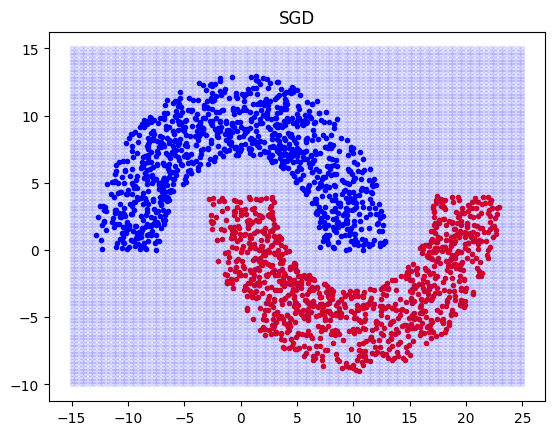

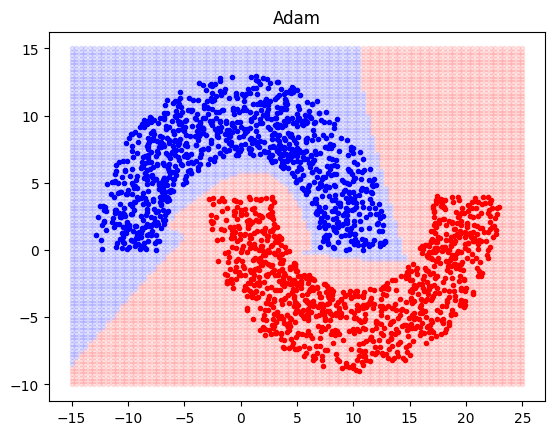

In [14]:
# Gera a curva de separação das duas regiões
# Dados da curva de separação
Nsep = 100
x1S = np.linspace(-15, 25, Nsep).reshape(-1, 1)
x2S = np.linspace(-10, 15, Nsep).reshape(-1, 1)

# Gera pontos da grade
xx1S, xx2S = np.meshgrid(x1S, x2S)
xx1S = xx1S.reshape(-1, 1)
xx2S = xx2S.reshape(-1, 1)

# Gera arrays x e d (nesse caso, d é "qualquer", apenas usado
# pois é entrada obrigatória da função redeMLP_teste()
xgrid = np.hstack((xx1S, xx2S))
Ngrid = len(xgrid)
dgrid = np.zeros((Ngrid, 1))

# Calcula saída para cada ponto da grade
(J_MSEgrid_SGD, ygrid_SGD) = redeMLP_teste(xgrid, dgrid, W_SGD, Nn, Ngrid)
(J_MSEgrid_Adam, ygrid_Adam) = redeMLP_teste(xgrid, dgrid, W_Adam, Nn, Ngrid)

ygrid_dec_SGD = np.sign(ygrid_SGD)
ygrid_dec_Adam = np.sign(ygrid_Adam)

# Plota os pontos principais - SGD
fig, ax2 = plt.subplots()
for i in range(Nteste):
    if dteste[i] == 1:
        ax2.plot(xteste[i, 0], xteste[i, 1], ".b")
    else:
        ax2.plot(xteste[i, 0], xteste[i, 1], ".r")

# Plota pontos da grade com saída 0 (usa transparência alpha)
l0 = np.where(ygrid_dec_SGD == -1)[0]
ax2.plot(xgrid[l0, 0], xgrid[l0, 1], "r.", alpha=0.1)

# Plota pontos da grade com saída 1 (usa transparência alpha)
l1 = np.where(ygrid_dec_SGD == 1)[0]
ax2.plot(xgrid[l1, 0], xgrid[l1, 1], "b.", alpha=0.1)
plt.title("SGD")

# Plota os pontos principais - Adam
fig, ax3 = plt.subplots()
for i in range(Nteste):
    if dteste[i] == 1:
        ax3.plot(xteste[i, 0], xteste[i, 1], ".b")
    else:
        ax3.plot(xteste[i, 0], xteste[i, 1], ".r")

# Plota pontos da grade com saída 0 (usa transparência alpha)
l0 = np.where(ygrid_dec_Adam == -1)[0]
ax3.plot(xgrid[l0, 0], xgrid[l0, 1], "r.", alpha=0.1)

# Plota pontos da grade com saída 1 (usa transparência alpha)
l1 = np.where(ygrid_dec_Adam == 1)[0]
ax3.plot(xgrid[l1, 0], xgrid[l1, 1], "b.", alpha=0.1)
plt.title("Adam")

Calula a taxa de erro em cada caso

In [15]:
yteste_dec_SGD = np.sign(yteste_SGD)
yteste_dec_Adam = np.sign(yteste_Adam)

Taxa_de_erro_SGD = np.sum(np.absolute(dteste - yteste_dec_SGD)) * 100 / (2 * Nteste)
Taxa_de_erro_Adam = np.sum(np.absolute(dteste - yteste_dec_Adam)) * 100 / (2 * Nteste)

print(f"Taxa de erro SGD: {Taxa_de_erro_SGD}")
print(f"Taxa de erro Adam: {Taxa_de_erro_Adam}")

Taxa de erro SGD: 50.0
Taxa de erro Adam: 0.0
